# Project 3

**Gillian McGovern, Dhanya Nair, Dirk Hartog**

Project Requirement:

Split the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set.

Answer the questions:


*   How does the performance on the test set compare to the performance on the dev-test set?
*   Is this what you'd expect?

Source: Natural Language Processing with Python, exercise 6.10.2.

# Import Data



In [ ]:
import random
import nltk
from nltk.corpus import names #it contains lists of male and female first names.
import matplotlib.pyplot as plt
import seaborn as sns


# Download names corpus if not already downloaded
nltk.download('names')

# Load the labeled names corpus
labeled_names = ([(name, 'male') for name in names.words('male.txt')] +
                 [(name, 'female') for name in names.words('female.txt')])

# shuffle the names to avoid bias in the dataset ordering (e.g., all male names first).
random.seed(123)
random.shuffle(labeled_names)

# Split the data
test_set = labeled_names[:500]
devtest_set = labeled_names[500:1000]
train_set = labeled_names[1000:]

# display the size
print(f"Training set size: {len(train_set)}")
print(f"Dev-test set size: {len(devtest_set)}")
print(f"Test set size: {len(test_set)}")


Training set size: 6944
Dev-test set size: 500
Test set size: 500


[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.


# Naive Bayes Base Model

In [ ]:
# Feature extractor (baseline = last letter)
def gender_features(word):
    return {'last_letter': word[-1].lower()}

# Apply features
train_feats = [(gender_features(n), g) for (n, g) in train_set]
devtest_feats = [(gender_features(n), g) for (n, g) in devtest_set]
test_feats = [(gender_features(n), g) for (n, g) in test_set]

# Train classifier
classifier = nltk.NaiveBayesClassifier.train(train_feats)

# Evaluate
print("Dev-test accuracy:", nltk.classify.accuracy(classifier, devtest_feats))
print("Test accuracy:", nltk.classify.accuracy(classifier, test_feats))


Dev-test accuracy: 0.78
Test accuracy: 0.778


In [ ]:
classifier.show_most_informative_features(5)


Most Informative Features
             last_letter = 'a'            female : male   =     33.3 : 1.0
             last_letter = 'k'              male : female =     29.2 : 1.0
             last_letter = 'p'              male : female =     18.6 : 1.0
             last_letter = 'f'              male : female =     15.2 : 1.0
             last_letter = 'v'              male : female =      9.8 : 1.0


Most informative feature for this model is if the name ends with an `a` indicating it is a female. This is closely followed by the name ending in `k` indicating a male name.

# Naive Bayes Model 2

In [ ]:
# Additional features to model 1

def gender_features2(word):
    return {
        'last_letter': word[-1].lower(),
        'last_two': word[-2:].lower(),
        'first_letter': word[0].lower(),
        'length': len(word),
        'has_vowel': any(c in 'aeiou' for c in word.lower())
    }

# Rebuild sets
train_feats2 = [(gender_features2(n), g) for (n, g) in train_set]
devtest_feats2 = [(gender_features2(n), g) for (n, g) in devtest_set]
test_feats2 = [(gender_features2(n), g) for (n, g) in test_set]

# Retrain
classifier2 = nltk.NaiveBayesClassifier.train(train_feats2)

# Re-evaluate
print("Improved Dev-test accuracy:", nltk.classify.accuracy(classifier2, devtest_feats2))
print("Improved Test accuracy:", nltk.classify.accuracy(classifier2, test_feats2))
classifier2.show_most_informative_features(10)


Improved Dev-test accuracy: 0.802
Improved Test accuracy: 0.786
Most Informative Features
                last_two = 'na'           female : male   =    159.6 : 1.0
                last_two = 'la'           female : male   =     73.3 : 1.0
                last_two = 'ia'           female : male   =     36.0 : 1.0
                last_two = 'sa'           female : male   =     33.9 : 1.0
             last_letter = 'a'            female : male   =     33.3 : 1.0
                last_two = 'ta'           female : male   =     30.9 : 1.0
                last_two = 'rt'             male : female =     30.2 : 1.0
             last_letter = 'k'              male : female =     29.2 : 1.0
                last_two = 'rd'             male : female =     28.7 : 1.0
                last_two = 'us'             male : female =     28.7 : 1.0


In most cases, performance on the dev-test is slightly higher than on the test set because the classifier has indirectly been tuned using the dev-test set. Also, the test set represents a truly unseen dataset, making it more realistic.

A more accurate dev-test is expected. Using the dev-test set for model selection or feature tuning makes it slightly optimistic. The test set serves as an unbiased estimate of generalization performance.



## Model 2 Evaluation

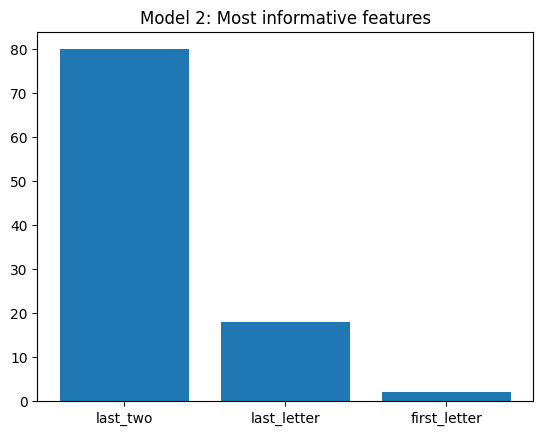

In [ ]:
top_features = {}

for (feat, i) in classifier2.most_informative_features(100):
  if feat not in top_features.keys():
    top_features[feat] = 1
  else:
    top_features[feat] += 1

plt.bar(x = top_features.keys(), height = top_features.values())
plt.title("Model 2: Most informative features")
plt.show()

In [ ]:
# Get errors

errors = []
for (name, tag) in devtest_set:
    guess = classifier2.classify(gender_features2(name))
    if guess != tag:
        errors.append( (tag, guess, name) )

# Print out the first 10 errors
male_errors_counts = {}
female_errors_counts = {}

for (tag, guess, name) in sorted(errors):
  if guess == 'male':
    if name[-1] in male_errors_counts.keys():
      male_errors_counts[name[-1]] += 1
    else:
      male_errors_counts[name[-1]] = 1
  else:
    if name[-1] in female_errors_counts.keys():
      female_errors_counts[name[-1]] += 1
    else:
      female_errors_counts[name[-1]] = 1


#print('correct={:<8} guess={:<8s} name={:<30}'.format(tag, guess, name))

In [ ]:
# Count of ending letter of Names incorrectly identified as 'male'
sorted(male_errors_counts.items(), key = lambda x: x[1], reverse = True)

[('n', 18),
 ('y', 11),
 ('l', 5),
 ('t', 4),
 ('s', 3),
 ('r', 3),
 ('m', 2),
 ('h', 2),
 ('o', 2),
 ('w', 1),
 ('d', 1),
 ('e', 1)]

In [ ]:
# Count of ending letter of Names incorrectly identified as 'female'
sorted(female_errors_counts.items(), key = lambda x: x[1], reverse = True)

[('e', 28), ('y', 5), ('i', 4), ('n', 4), ('l', 3), ('a', 1), ('h', 1)]

Feature Engineering/Selection continued

Within the 105 errors made by the second model:
- 12 names were **incorrectly identified as male** when the name ended in 'l'
- 29 names were **incorrectly identified as female** when the name ended in 'e'

The last two letters dominated the top 10 most informative fearture list with 8/10, while the only other infomative feature in this list was the last letter. This indicates the ending of the name is more informative than the beginning of a name, and a bigram token (2 letters) is more useful than a unigram. These two features may seem kind of redundant. We can experiment with the current features for any comibination that yields the highest accuracy.

# Naive Bayes Model 3

In [ ]:
import re
from nltk.tokenize import SyllableTokenizer

mappings = [('ph', 'f'), ('ght', 't'), ('^kn', 'n'), ('qu', 'kw'),
           ('[aeiou]+', 'a'), (r'(.)\1', r'\1')]

# Pronunciation using the above mappings (from textbook)
def signature(word):
  for patt, repl in mappings:
    word = re.sub(patt, repl, word)
  pieces = re.findall('[^aeiou]+', word)
  return ''.join(char for piece in pieces for char in sorted(piece))[:8]

# Syllable count
SSP = SyllableTokenizer()

def gender_features3(word):
    return {
        'last_two': word[-2:].lower(),
        'last_three': word[-3:].lower(),
        'first_letter': word[0].lower(),
        'length': len(word),
        'signature': signature(word), # pronunciation
        'syllable_count': len(SSP.tokenize(word)),
    }

# Rebuild sets
train_feats3 = [(gender_features3(n), g) for (n, g) in train_set]
devtest_feats3 = [(gender_features3(n), g) for (n, g) in devtest_set]
test_feats3 = [(gender_features3(n), g) for (n, g) in test_set]

# Retrain
classifier3 = nltk.NaiveBayesClassifier.train(train_feats3)

# Re-evaluate
print("Improved Dev-test accuracy:", nltk.classify.accuracy(classifier3, devtest_feats3))
print("Improved Test accuracy:", nltk.classify.accuracy(classifier3, test_feats3))
classifier3.show_most_informative_features(20)

Improved Dev-test accuracy: 0.82
Improved Test accuracy: 0.826
Most Informative Features
                last_two = 'na'           female : male   =    159.6 : 1.0
                last_two = 'la'           female : male   =     73.3 : 1.0
                last_two = 'ia'           female : male   =     36.0 : 1.0
                last_two = 'sa'           female : male   =     33.9 : 1.0
                last_two = 'ta'           female : male   =     30.9 : 1.0
                last_two = 'rt'             male : female =     30.2 : 1.0
                last_two = 'rd'             male : female =     28.7 : 1.0
                last_two = 'us'             male : female =     28.7 : 1.0
              last_three = 'ard'            male : female =     25.8 : 1.0
              last_three = 'ita'          female : male   =     25.6 : 1.0
                last_two = 'ra'           female : male   =     24.0 : 1.0
              last_three = 'ana'          female : male   =     23.8 : 1.0
           

## Model 3 Evaluation

In [ ]:
top_features = {}

for (feat, i) in classifier3.most_informative_features(100):
  if feat not in top_features.keys():
    top_features[feat] = 1
  else:
    top_features[feat] += 1

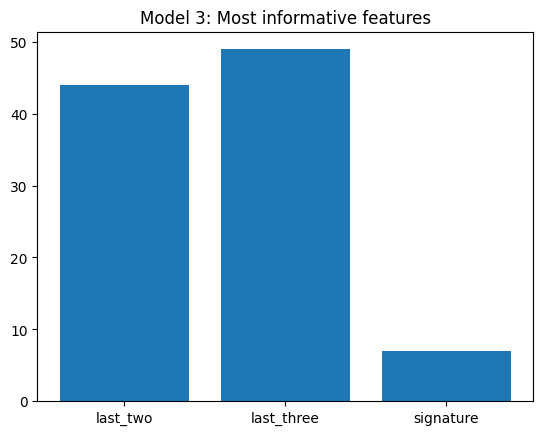

In [ ]:
plt.bar(x = top_features.keys(), height = top_features.values())
plt.title("Model 3: Most informative features")
plt.show()

In this third iteration of a Naive Bayes model to predict the label of a name as male or female, eliminating the "last_letter" feature improved the accuracy, while including the 'has_vowel' feature did not impact the accuarcy in either direction. Additionally, using the "last_three" letters proved to be more useful than just the "last_two" as it had a higher count for the overall top 100 most informative features. Although, the most important feature is still the last two letters ('na'). Adding the pronunciation of the name improved the model very slightly, while adding the syllable count did not have any effect.

Again, having the last two and three letters seems redundant, but removing one of those features hurts the model's accuracy.

# Decision Tree Base Model

In [ ]:
# Use the train and devtest_feats from the Naive Base model
## train_feats
## devtest_feats
## test_feats

dt_classifier = nltk.DecisionTreeClassifier.train(train_feats)

nltk.classify.accuracy(classifier, devtest_feats)

0.78

In [ ]:
# Print the Decision Tree
print(dt_classifier.pseudocode(depth=4))

if last_letter == ' ': return 'female'
if last_letter == 'a': return 'female'
if last_letter == 'b': return 'male'
if last_letter == 'c': return 'male'
if last_letter == 'd': return 'male'
if last_letter == 'e': return 'female'
if last_letter == 'f': return 'male'
if last_letter == 'g': return 'male'
if last_letter == 'h': return 'female'
if last_letter == 'i': return 'female'
if last_letter == 'j': return 'male'
if last_letter == 'k': return 'male'
if last_letter == 'l': return 'male'
if last_letter == 'm': return 'male'
if last_letter == 'n': return 'male'
if last_letter == 'o': return 'male'
if last_letter == 'p': return 'male'
if last_letter == 'r': return 'male'
if last_letter == 's': return 'male'
if last_letter == 't': return 'male'
if last_letter == 'u': return 'male'
if last_letter == 'v': return 'male'
if last_letter == 'w': return 'male'
if last_letter == 'x': return 'male'
if last_letter == 'y': return 'female'
if last_letter == 'z': return 'male'



# Random Forest Model

In [ ]:
# prompt: perform the same classification but with random forest

from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Function to convert NLTK features to a format scikit-learn can use
def convert_nltk_feats_to_sklearn(nltk_feats):
    X = [feat for (feat, label) in nltk_feats]
    y = [label for (feat, label) in nltk_feats]
    return X, y

# Convert NLTK features to scikit-learn compatible format
X_train, y_train = convert_nltk_feats_to_sklearn(train_feats)
X_devtest, y_devtest = convert_nltk_feats_to_sklearn(devtest_feats)
X_test, y_test = convert_nltk_feats_to_sklearn(test_feats)

# Vectorize the dictionary features
vec = DictVectorizer(sparse=False)
X_train_vec = vec.fit_transform(X_train)
X_devtest_vec = vec.transform(X_devtest)
X_test_vec = vec.transform(X_test)

# Train Random Forest Classifier
# Using a simple set of parameters for demonstration
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=123)
rf_classifier.fit(X_train_vec, y_train)

# Evaluate on dev-test set
y_devtest_pred = rf_classifier.predict(X_devtest_vec)
rf_devtest_accuracy = accuracy_score(y_devtest, y_devtest_pred)
print("Random Forest Dev-test accuracy:", rf_devtest_accuracy)

# Evaluate on test set
y_test_pred = rf_classifier.predict(X_test_vec)
rf_test_accuracy = accuracy_score(y_test, y_test_pred)
print("Random Forest Test accuracy:", rf_test_accuracy)

# inspect feature importance
print("Random Forest Feature Importance:")
for feature, importance in zip(vec.feature_names_, rf_classifier.feature_importances_):
     print(f"{feature}: {importance:.4f}")


Random Forest Dev-test accuracy: 0.782
Random Forest Test accuracy: 0.776
Random Forest Feature Importance:
last_letter= : 0.0007
last_letter=a: 0.4014
last_letter=b: 0.0021
last_letter=c: 0.0116
last_letter=d: 0.0741
last_letter=e: 0.1192
last_letter=f: 0.0072
last_letter=g: 0.0038
last_letter=h: 0.0080
last_letter=i: 0.0660
last_letter=j: 0.0005
last_letter=k: 0.0263
last_letter=l: 0.0108
last_letter=m: 0.0206
last_letter=n: 0.0296
last_letter=o: 0.0502
last_letter=p: 0.0057
last_letter=r: 0.0503
last_letter=s: 0.0480
last_letter=t: 0.0279
last_letter=u: 0.0015
last_letter=v: 0.0037
last_letter=w: 0.0042
last_letter=x: 0.0013
last_letter=y: 0.0236
last_letter=z: 0.0015


**Summary**


1. In most cases, performance on the dev-test is slightly higher than on the test set because the classifier has indirectly been tuned using the dev-test set. Also, the test set represents a truly unseen dataset, making it more realistic.

2. A more accurate dev-test is expected. Using the dev-test set for model selection or feature tuning makes it slightly optimistic. The test set serves as an unbiased estimate of generalization performance.

3. Three classifiers Naive Bayes, Decision Tree and Random Forest were tested with features. Naive Bayes (82.6%) was the most optimal classifier for devtest and test dataset.

4. Last_two feature has the maximum test accuracy performance.

